# Определение стоимости автомобилей

Содержание

### Описание данных
Данные находятся в файле /datasets/autos.csv.
#### Признаки
`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

#### Целевой признак
`Price` — цена (евро)

## Импорт библиотек, настроек и функций

In [98]:
!pip install category_encoders

In [99]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, make_scorer

from category_encoders.m_estimate import MEstimateEncoder

In [100]:
pd.options.mode.chained_assignment = None
matplotlib.rc('figure', figsize=(10, 5))
sns.set_palette("pastel")

In [101]:
def dataframe_info(df):
    display(df.head())
    print('SHAPE:', df.shape)
    df.info()
    print('DUPLICATES:', df.duplicated().sum())
    sns.boxplot(data=df[df.select_dtypes(np.number).columns.tolist()])
    plt.show()

## Подготовка данных

In [102]:
try:
   df = pd.read_csv('datasets/autos.csv')
except:
   df = pd.read_csv('/datasets/autos.csv')

In [103]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Чтобы не делать лишней обработки, сначала уберём даныне, которые не влияют на стотимость авто. В данном случае это
- `DateCrawled` — дата скачивания анкеты из базы
- `RegistrationMonth` — месяц регистрации автомобил
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Месяц регистрации автомобил и почтовый индекс пользователя (а значит регион продажи) имеют влияние на цену автомобиля, но в рамках учебного проекта, положим что они влияние не оказывают.

In [104]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [73]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


SHAPE: (354369, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
DUPLICATES: 45040


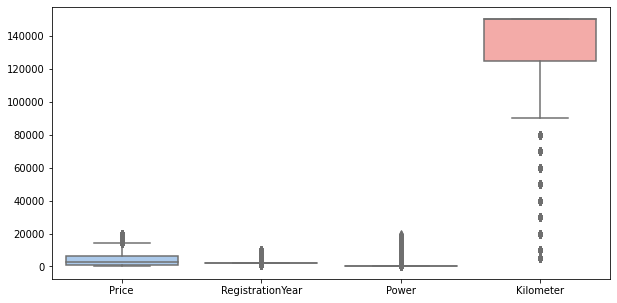

In [74]:
dataframe_info(df)

В датасете 354369 строк, есть пропуски и незаполненные значения. Теперь рассмотри каждую колонку отдельно и начнем с признаков, например с года выпуска.

#### Год выпуска

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


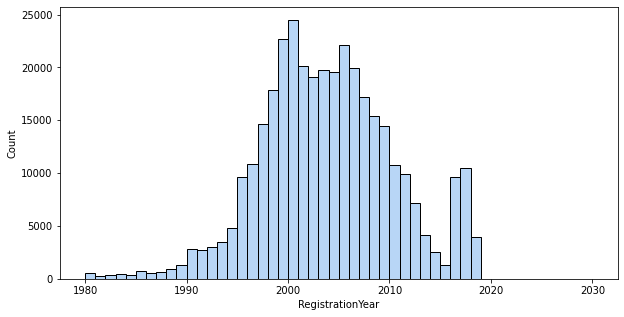

In [75]:
print(df['RegistrationYear'].describe())
sns.histplot(df['RegistrationYear'], bins=50, binrange=(1980,2030))
plt.show()


Мой личный опыт говорит о том, что прогнозировать стоимость машины старше 15 лет не имеет особого смысла, так как наибольший вес имеет текущее состояние машины и разброс бывает очень большой. Для того чтобы показать пользователю хотя бы порядок суммы, на которую он сможет расчитывать и в академических целях, обучать будет на машинах, выпущенных после 1990 года.

In [107]:
df = df[(df['RegistrationYear'] > 1995) & (df['RegistrationYear'] < 2016)]
df.shape

(294115, 16)

#### Марка

In [77]:
print(df['Brand'].value_counts(dropna=False))

volkswagen        66184
opel              36263
bmw               32850
mercedes_benz     27629
audi              26364
ford              23671
renault           17205
peugeot           10562
fiat               8891
seat               6729
skoda              5434
smart              5243
mazda              5144
citroen            4876
nissan             4486
toyota             4276
hyundai            3556
mini               3132
volvo              2798
mitsubishi         2775
kia                2441
honda              2354
alfa_romeo         2152
sonstige_autos     2052
suzuki             2040
chevrolet          1408
chrysler           1328
dacia               898
daihatsu            742
subaru              664
porsche             541
daewoo              540
jeep                518
land_rover          481
rover               455
saab                427
jaguar              419
lancia              413
lada                172
trabant              26
Name: Brand, dtype: int64


40 брендов, неявных дубликатов нет, пропусков нет.

#### Кузов

In [78]:
print(df['VehicleType'].value_counts(dropna=False))
print(df.shape)

sedan          79125
small          73440
wagon          62055
NaN            33559
bus            27114
convertible    16919
coupe          12506
suv            10878
other           2543
Name: VehicleType, dtype: int64
(318139, 10)


Очистим данные от путсых и редких моделей

In [79]:
df = df.dropna(subset=['Model'])

lf_models = df['Model'].value_counts()
lf_models = lf_models[lf_models < 50]
df = df[~df['Model'].isin(lf_models.index)]
print(df.shape)
df['Model'].value_counts(dropna=False)

(301849, 10)


golf                 24295
other                17953
3er                  16980
corsa                11551
polo                 11321
                     ...  
defender                59
911                     55
lybra                   54
range_rover_sport       54
wrangler                54
Name: Model, Length: 217, dtype: int64

Попробуем заполнить пропуски по информации в других строка, с совпадающими брендом, моделью и годом выпуска

Пока не нашел способ векторного заполнения , а выбранный мной способ работает больше 10 минут на локальном компьютере, поэтому я его закомментировал, а пропуски просто удаляю, для экономии времени ревьюера

In [80]:
print(df['VehicleType'].value_counts(dropna=False))

sedan          76575
small          70560
wagon          60001
NaN            27762
bus            26215
convertible    16326
coupe          11977
suv            10217
other           2216
Name: VehicleType, dtype: int64


In [81]:
print(df.shape)
#df.groupby(by=['Brand', 'Model', 'RegistrationYear'], dropna=False)["VehicleType"].head()
#df.groupby(by=['Brand', 'Model', 'RegistrationYear'], dropna=False)["VehicleType"].transform(lambda x: x)
#df['VehicleType'].fillna(df.groupby(by=['Brand', 'Model', 'RegistrationYear'])['VehicleType'].transform())
def get_type(x):
    if x.value_counts().size:
        return x.fillna(x.value_counts().idxmax())
        
    return None

df['VehicleType'] = df['VehicleType'].fillna(df 
                            .groupby(by=['Brand', 'Model', 'RegistrationYear'], dropna=False)['VehicleType']
                            .transform(lambda x: get_type(x)))


(301849, 10)


In [82]:
print(df['VehicleType'].value_counts(dropna=False))

sedan          80552
small          75541
wagon          62073
bus            27559
convertible    17690
NaN            12884
coupe          12791
suv            10451
other           2308
Name: VehicleType, dtype: int64


In [83]:
df = df.dropna(subset=['VehicleType'])
print(df['VehicleType'].value_counts(dropna=False))

sedan          80552
small          75541
wagon          62073
bus            27559
convertible    17690
coupe          12791
suv            10451
other           2308
Name: VehicleType, dtype: int64


#### КПП

In [84]:
print(df['Gearbox'].value_counts(dropna=False))

manual    221239
auto       56248
NaN        11478
Name: Gearbox, dtype: int64


Какого то вменяемого алгоритма заполнения я не придумал, так как одна и та же модель, может быть как на ручной так и на автоматической КПП, поэтому чтобы не навредить - удалим

In [85]:
df = df.dropna(subset=['Gearbox'])
df.shape

(277487, 10)

#### Мощность

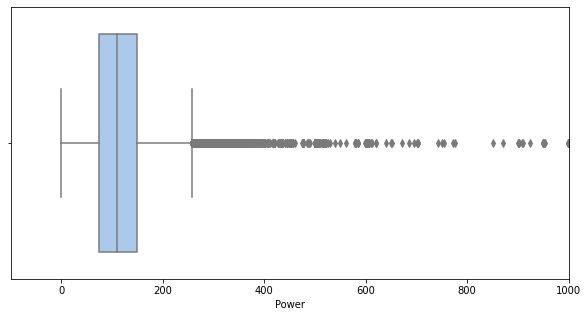

In [86]:
sns.boxplot(x=df['Power']);
plt.xlim(-100, 1000)
plt.show()

Предсказывать цену гиперкаров с мощностью более 500 сил мы небудем, как и цену газонокосилок. Чтоб отбросить эти варианты и другие аномалии, оставим только строки с мощностью в границах 50-500 лошадиных сил

In [87]:
df = df[(df['Power'] > 50) & (df['Power'] < 500)]
df.shape

(252877, 10)

#### Пробег

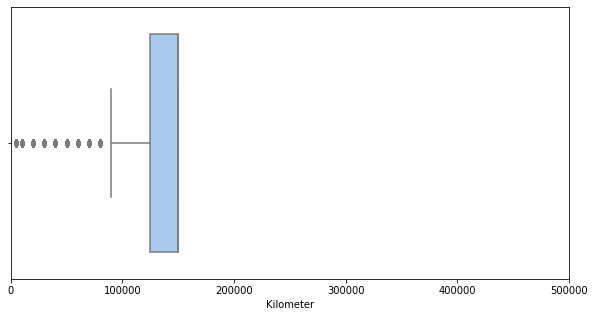

In [88]:
sns.boxplot(x=df['Kilometer']);
plt.xlim(-100, 500000)
plt.show()

С пробегом вроде все хорошо. Большинство машин уже успели наездить более 80 тысяч, но есть варианты и с минимальным пробегом.

#### Вид топлива

In [89]:
print(df['FuelType'].value_counts(dropna=False))


petrol      154653
gasoline     83216
NaN          10261
lpg           4051
cng            454
hybrid         172
other           40
electric        30
Name: FuelType, dtype: int64


`petrol` и `gasoline` это бензин, просто его называют по разному в USA и UK. Почему на одном сайте доступны два вида топлива, означающих одно и то же - для меня загадка, как и отсутствие дизеля. Обработаем данные в два этапа. Заменить gasoline на petrol  и потом уберём пропуски


In [90]:
df.loc[df['FuelType'] == 'gasoline']['FuelType'] = 'petrol'
df = df.dropna(subset=['FuelType'])
df.shape

(242616, 10)

#### Был ли автомобиль в ремонте

In [91]:
df['Repaired'].value_counts(dropna=False)

no     192099
NaN     28481
yes     22036
Name: Repaired, dtype: int64

Назаполненные данные лучше удалить чем некорректно проставить значения.

In [92]:
df = df.dropna(subset=['Repaired'])
df.shape

(214135, 10)

#### Цена

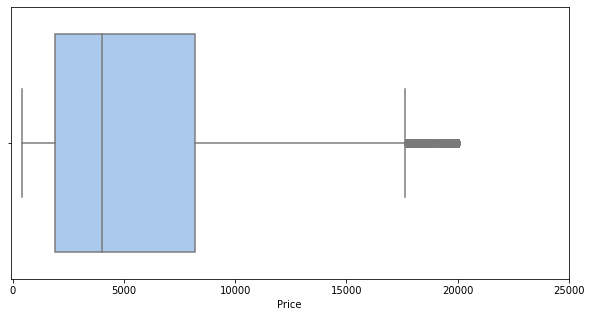

In [96]:
sns.boxplot(x=df['Price']);
plt.xlim(-100, 25000)
plt.show()

In [29]:
print(df['Price'].quantile(0.05), df['Price'].quantile(0.95))

550.0 15850.0


Из датасета уберём позиции с аномально низкой и выскоой ценой

In [95]:
expensive_cars = df[df['Price'] >= 15600]
df = df[df['Price'] > 400]
df.shape

(207036, 10)

In [37]:
print(expensive_cars.shape)
pt = expensive_cars.pivot_table(index=['Brand', 'Model', 'RegistrationYear'], values='Price', aggfunc="count")
display(pt[pt['Price']>50])

(11214, 10)


Price
Brand         Model       RegistrationYear       
audi          a1          2014                 66
              a3          2012                 78
                          2013                 64
                          2014                 52
              a4          2008                 68
                          2009                 78
                          2010                 80
                          2011                106
                          2012                 66
              a5          2008                 73
                          2009                 93
                          2010                 88
              a6          2009                 58
                          2010                 68
                          2011                 59
bmw           1er         2009                 60
                          2010                 59
                          2011                 77
                          2012                 82
              3er         2007                110
                          2008                119
                          2009                 94
                          2010                145
                          2011                126
                          2012                 53
              5er         2008                 96
                          2009                 82
                          2010                105
                          2011                 76
              x_reihe     2007                 65
                          2008                 61
                          2010                 62
                          2011                 67
mercedes_benz a_klasse    2013                 65
              c_klasse    2009                 67
                          2010                 73
                          2011                164
                          2012                 97
              e_klasse    2009                118
                          2010                109
                          2011                 53
mini          cooper      2011                 91
                          2012                 78
volkswagen    golf        2010                 72
                          2011                132
                          2012                179
                          2013                163
                          2014                186
                          2015                 83
              passat      2011                 87
                          2012                 62
              tiguan      2011                 51
                          2012                 51
              touran      2011                 67
                          2012                 62
              transporter 2006                 57
                          2007                 54

In [30]:
df['Price'].describe()

count    195822.000000
mean       4991.205375
std        3864.408900
min         408.000000
25%        1800.000000
50%        3850.000000
75%        7350.000000
max       15599.000000
Name: Price, dtype: float64

#### Модель

In [31]:
print(df['Model'].value_counts(dropna=False))

golf                 16027
other                11829
3er                  11791
a4                    6436
astra                 6392
                     ...  
defender                27
range_rover_sport       26
911                     10
move                     8
glk                      6
Name: Model, Length: 217, dtype: int64


Почти 19 тысяч авто без указанной модели, и есть какие то уникальные модели, которых единицы на выборку в 360 тысяч объявлений. Такие строки проще удалить, чем искать анализировать, почему так произошло. А вот на объявления без указанной модели посмотрим поближе.

In [32]:
df[df['Model'].isna()].head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


Абсолютно разные бренды, года выпуска и пробег. Не вижу возможности заполнить модель каким то алгоритмом, поэтому удалим эти строки

In [33]:
df = df.dropna(subset=['Model'])

In [34]:
lf_models = df['Model'].value_counts()
lf_models = lf_models[lf_models < 50]
print(lf_models)
df = df[~df['Model'].isin(lf_models.index)]
print(df.shape)

m_reihe              47
range_rover          46
6er                  45
crossfire            45
mustang              41
q5                   41
calibra              33
nubira               33
lanos                31
lybra                30
cx_reihe             30
wrangler             27
defender             27
range_rover_sport    26
911                  10
move                  8
glk                   6
Name: Model, dtype: int64
(195296, 10)


### Вывод
Удалили неинформативные признаки. Заполнили пропуски в столбце Тип кузова и удалили строки с пропусками в остальных признаках. Ограничили год выпуска периода с 1995 по 2020, мощность с 50 до 500, и цену с 400 до 15600. В результате подготовки данных количество строк уменьшилось с   354369 до 164672, зато данные качественные.

## Обучение моделей

In [35]:
def rmse(target, predictions):
    return np.sqrt(mean_squared_error(target, predictions))

rmse_scorer = make_scorer(rmse)

In [36]:
X = df.drop(columns='Price', axis=1)
y = df['Price']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31337)



print(x_train.shape)
print(x_test.shape)

(156236, 9)
(39060, 9)


### LinearRegression

In [37]:
x_valid, x_test, y_valid, y_test = train_test_split(x_train, y_train, test_size=0.8, random_state=31337)
print(x_valid.shape)

(31247, 9)


In [38]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()


cat_features = X.select_dtypes('object').columns.tolist()
num_features = X.select_dtypes(np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', cat_transformer, ['VehicleType',  'Gearbox', 'FuelType', 'Repaired']),
        ('cat_mee', MEstimateEncoder(), ['Brand', 'Model']),
        ('num', num_transformer, make_column_selector(dtype_include=np.number))
    ])
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor' , LinearRegression())])

lr_model.fit(x_train,y_train)

scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring=rmse_scorer)

print('RMSE линейной регрессии:', scores.mean())

RMSE линейной регрессии: 1999.4630645502828


### CatBoost

In [39]:
%%time 

cb_model = CatBoostRegressor(random_seed=31337,
                          iterations=50,
                          learning_rate=1,
                          depth=2,
                          custom_metric='RMSE',
                          cat_features=cat_features,
                          )

#rid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

param_grid = {
    'num_leaves': [31, 127],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01]
}

grid_search_result = cb_model.grid_search(param_grid,
            X=x_train,
            y=y_train,
            cv=3,
            partition_random_seed=31337,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=False)


print('RMSE CatBoost:', cb_model.best_score_)


0:	learn: 5792.4226503	test: 5803.4871666	best: 5803.4871666 (0)	total: 85.3ms	remaining: 4.18s
1:	learn: 5341.1970638	test: 5353.5062843	best: 5353.5062843 (1)	total: 114ms	remaining: 2.74s
2:	learn: 4944.3921087	test: 4957.9475385	best: 4957.9475385 (2)	total: 136ms	remaining: 2.13s
3:	learn: 4593.1168239	test: 4607.6960684	best: 4607.6960684 (3)	total: 167ms	remaining: 1.92s
4:	learn: 4282.4070074	test: 4297.9184380	best: 4297.9184380 (4)	total: 190ms	remaining: 1.71s
5:	learn: 4009.4978058	test: 4026.9384729	best: 4026.9384729 (5)	total: 211ms	remaining: 1.55s
6:	learn: 3768.9193598	test: 3786.4456155	best: 3786.4456155 (6)	total: 232ms	remaining: 1.43s
7:	learn: 3560.6673426	test: 3578.3027656	best: 3578.3027656 (7)	total: 254ms	remaining: 1.33s
8:	learn: 3375.3005153	test: 3392.6849933	best: 3392.6849933 (8)	total: 275ms	remaining: 1.25s
9:	learn: 3216.4128117	test: 3234.1287617	best: 3234.1287617 (9)	total: 296ms	remaining: 1.18s
10:	learn: 3079.0838657	test: 3098.0733221	best: 

### LightGBM

Кодируем категории

тут я пытался самостоятельно закодировать категории, чтобы попробовать как их переварит lgbm

In [40]:

#x_train_copy = x_train.copy()
#
#for cat_f in cat_features:
#    x_train_copy[cat_f] = pd.Categorical(x_train_copy[cat_f])
#    x_train_copy[cat_f] = x_train_copy[cat_f].cat.codes
#
#display(x_train_copy.head())

In [41]:
#train_data = lgb.Dataset(x_train_copy, label=y_train, categorical_feature=[0,2,4,6,7,8], free_raw_data=False)
#validation_data = train_data.create_valid('validation.svm')

In [42]:
#num_transformer = StandardScaler()
#cat_transformer = OneHotEncoder()
#
#num_features = X.select_dtypes(np.number).columns.tolist()
#cat_features = X.select_dtypes('object').columns.tolist()
#
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat_ohe', cat_transformer, ['VehicleType',  'Gearbox', 'FuelType', 'Repaired']),
#        ('cat_mee', MEstimateEncoder(), ['Brand', 'Model']),
#        ('num', num_transformer, make_column_selector(dtype_include=np.number))
#    ])


#y_pred = lr_model.predict(x_valid)

#param_grid = {
#    'num_leaves': [31, 127],
#    'n_estimators': [50, 100, 150],
#    'learning_rate': [0.1, 0.01]
#}
#
#lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt',  objective='regression')
#
#lgb_model = Pipeline(steps=[('preprocessor', preprocessor),
#                           ('regressor' , GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=5, scoring=rmse_scorer, refit=True))])
#lgb_model.fit(x_train,y_train)

#print(lgb_model.score)

<function Pipeline.score at 0x7fc00aa50700>
CPU times: user 7min 8s, sys: 3.28 s, total: 7min 11s
Wall time: 7min 15s


In [46]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', OneHotEncoder(), ['VehicleType',  'Gearbox', 'FuelType', 'Repaired']),
        ('cat_mee', MEstimateEncoder(), ['Brand', 'Model']),
        ('num', num_transformer, make_column_selector(dtype_include=np.number))
    ])

lgb_regressor = lgb.LGBMRegressor(boosting_type='gbdt',  objective='regression')

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor' , lgb_regressor)
])

param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__learning_rate' : [0.1, 0.01]
    }


gscv = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring=rmse_scorer, refit=True)

gscv.fit(x_train,y_train)
lgb_model = gscv.best_estimator_
print(gscv.best_score_)

2772.796527387675
CPU times: user 2min 56s, sys: 1.43 s, total: 2min 58s
Wall time: 2min 59s


## Анализ моделей

In [47]:
print('RMSE на тестовых данных')
print("LogisticRegression RMSE:", rmse(y_test, lr_model.predict(x_test)))
print("CatBoost RMSE:", rmse(y_test, cb_model.predict(x_test)))
print("LightGBM RMSE:", rmse(y_test, lgb_model.predict(x_test)))

RMSE на тестовых данных
LogisticRegression RMSE: 1997.8457241245228
CatBoost RMSE: 1655.6030983077999
LightGBM RMSE: 2764.244111775038


## ВЫВОД
Данные были очищены от пропусков и аномалий. Заполнены пропуски в типе кузова, по данным идентичных моделей.  
Для предсказания цены автомобиля были обучены три модели: Линеная регрессия, CatBoost и LightGBM.

Лучшую скорость показала линейная регрессия, но она обучалась без перебора метапараметров.
Лучшее качество показала модель CatBoost.
Модель LightGBM показала худшее из всех качество и скорость обучения. 
